# The HP model

This notebook contains code that exhaustively enumerates all possible conformations of an HP lattice protein. There are also functions to

* count the number of topological contacts
* compute the energy of a given conformation and sequence
* select the compact conformations out of a set of generic conformations
* given a sequence and a set of conformations, find the lowest-energy structures
* use `matplotlib` to show a conformation

At the end you can also find some example code that uses these functions.

In [1]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [2]:
# On a square lattice there are four possible directions (up, right, down, left)
DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]

# Return all possible conformations of a given length
def generate_conformations(length):
    # there is a single conformation of length 2 that is not related to others by rotations or translations
    if length == 2:
        return [[(0, 0), (0, 1)]] # this return stops the recursion of the next line
    
    # Recursive call: get all possible conformations for length - 1
    smaller_conformations = generate_conformations(length - 1)
    conformations = []
    
    for conf in smaller_conformations:
        last_point = conf[-1]
        for direction in DIRECTIONS:
            new_point = (last_point[0] + direction[0], last_point[1] + direction[1])
            if new_point not in conf: # check that there are no overlaps
                # generate the new configuration
                new_conf = conf + [new_point]
                # generate its mirror image
                mirror_conf = [(-x, y) for x, y in new_conf]
                # pick one of the two using the lexographic order through min
                conformations.append(min(new_conf, mirror_conf))
    
    # make sure that only one of the two mirror images of each configuration is retained
    conformations.sort()
    return list(conformations for conformations, _ in itertools.groupby(conformations))

# Return the number of topological contacts in a conformation
def count_topological_contacts(conformation):
    count = 0
    length = len(conformation)
    for i in range(length):
        for j in range(i + 2, length): # + 2 to skip connected neighbours
            if is_adjacent(conformation[i], conformation[j]):
                count += 1
    return count

# Return the conformations with the maximum compactness (i.e. with the maximum number of topological contacts)
def select_compact_conformations(conformations):
    max_topological_contacts = 0
    compact_conformations = []

    for conf in conformations:
        topological_contacts = count_topological_contacts(conf)
        if topological_contacts > max_topological_contacts:
            max_topological_contacts = topological_contacts
            compact_conformations = [conf]
        elif topological_contacts == max_topological_contacts:
            compact_conformations.append(conf)
    
    return max_topological_contacts, compact_conformations

# Return the energy of a conformation for a given HP sequence
def calculate_energy(conformation, sequence):
    energy = 0
    length = len(conformation)
    for i in range(length):
        if sequence[i] == 'H':
            for j in range(i + 2, length): # + 2 to skip connected neighbours
                if sequence[j] == 'H' and is_adjacent(conformation[i], conformation[j]):
                    energy -= 1
    return energy

# Check if two points are adjacent in the lattice
def is_adjacent(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1]) == 1

# Return the lowest energy conformations
def find_lowest_energy_conformations(sequence, conformations):
    length = len(sequence)
    if length != len(conformations[0]):
        print(f"The length of the sequence ({length}) is different from that of the conformations ({len(conformations[0])})")
    lowest_energy = float('inf')
    lowest_energy_conformations = []

    for conf in conformations:
        energy = calculate_energy(conf, sequence)
        if energy < lowest_energy:
            lowest_energy = energy
            lowest_energy_conformations = [conf]
        elif energy == lowest_energy:
            lowest_energy_conformations.append(conf)

    return lowest_energy, lowest_energy_conformations

# Plot the conformation, with each residue coloured according to the sequence
def plot_conformation(conformation, sequence):
    # define colors for H and P residues
    color_map = {'H': 'blue', 'P': 'red'}
    # used to shift the 'H' and 'P' labels so that they do not overlap with the symbols
    label_shift = 0.05
    
    # extract x and y coordinates
    x_coords, y_coords = zip(*conformation)
    
    # plot the conformation as a line connecting points
    plt.plot(x_coords, y_coords, color='black', linestyle='-', marker='o', linewidth=2)
    
    # plot each residue with its corresponding color
    for i, (x, y) in enumerate(conformation):
        plt.plot(x, y, marker='o', color=color_map[sequence[i]], markersize=10)
        # the first residue is labelled differently to highlight where the chain begins
        if i == 0:
            label = sequence[i] + " (N)"
        else:
            label = sequence[i]
        plt.text(x - label_shift, y + label_shift, label, fontsize=12, ha='right', va='bottom')

    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Conformation for sequence: {sequence}")
    plt.axis('off')
    plt.show()

Number of total conformations: 110188
Number of compact conformations: 360 (7 topological contacts)
Number of lowest-energy conformations: 1
Lowest Energy: -7


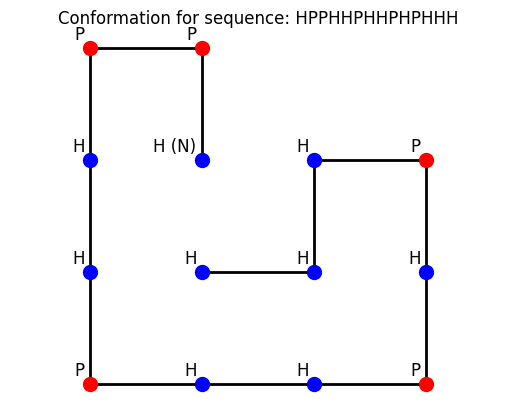

In [3]:
sequence = "HPPHHPHHPHPHHH"

conformations = generate_conformations(len(sequence))
max_topological_contacts, compact_conformations = select_compact_conformations(conformations)
lowest_energy, lowest_energy_conformations = find_lowest_energy_conformations(sequence, compact_conformations)

print(f"Number of total conformations: {len(conformations)}")
print(f"Number of compact conformations: {len(compact_conformations)} ({max_topological_contacts} topological contacts)")
print(f"Number of lowest-energy conformations: {len(lowest_energy_conformations)}")
print("Lowest Energy:", lowest_energy)
plot_conformation(lowest_energy_conformations[0], sequence)

Number of total conformations: 2034
Number of compact conformations: 98 (4 topological contacts)


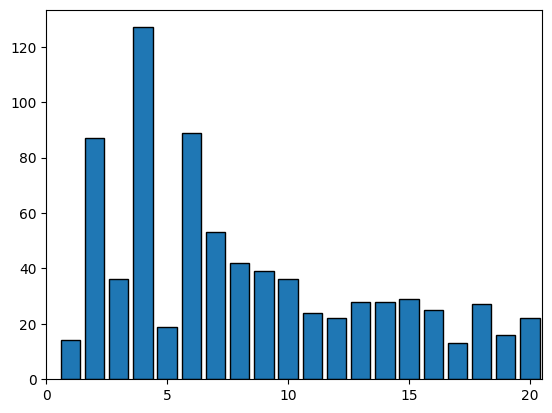

In [14]:
def generate_all_sequences(length):
    return [''.join(seq) for seq in itertools.product('HP', repeat=length)]

N = 10
conformations = generate_conformations(N)
max_topological_contacts, compact_conformations = select_compact_conformations(conformations)
print(f"Number of total conformations: {len(conformations)}")
print(f"Number of compact conformations: {len(compact_conformations)} ({max_topological_contacts} topological contacts)")
N_natives = []
for sequence in generate_all_sequences(N):
    lowest_energy, lowest_energy_conformations = find_lowest_energy_conformations(sequence, compact_conformations)
    N_natives.append(len(lowest_energy_conformations))

plt.xlim(0, 20.5)
plt.xticks(np.arange(0, 25, 5)) # set the tick label to multiples of 5
plt.hist(N_natives, bins=range(1, max(N_natives) + 1), ec='black', align='left', rwidth=0.8);